# 2024/02/26
OHボンドのWCと周囲の水素結合との関係を調べる．

## 水素結合の判定は，gromacsのgmx hbondに従う
https://www.compchems.com/how-to-study-hydrogen-bonds-using-gromacs/#hydrogen-bonds-in-molecular-dynamics-simulations

曰く，
1: 酸素間の距離 < 3.5Ang
2: O..O-Hの角度 < 30度
の二つの条件とのこと．これはかなり緩い条件だと思うが，とりあえずはこれでやってみよう．

これはLuzarのgeometry criterionと呼ばれているらしい．

The gmx hbond module determines the hydrogen bonds entirely based on geometry. More specifically, the H-bond interactions among two groups are based on two cutoffs:

The Ac–Dn–H angle between the three atoms involved in the hydrogen bond.
The distance between the two heavy atoms involved in the interaction (Ac–Dn).
When the angle and the distance are below a given cutoff the interaction is considered a hydrogen bond.

Default cutoffs
You can decide the cutoffs you prefer via some specific options. However, the default values are good for most applications:

Angle = 30°
Distance = 0.35 nm (3.5 Å)

In [1]:
import ase.io
import ase
traj = ase.io.read("mol_wan.xyz",index=":")
print(len(traj))

10001


In [2]:
len(traj[0])

544

In [3]:
len_traj = len(traj)
NUM_MOL = 32

In [ ]:
# 
# * 全ての分子間のペアijについて水素結合かどうか判定する．この時，iをdonorとすれば，iは最大でも1つのjとしかHBできない．

# * 水素結合の場合には，r_OOとr_OWCを計算

In [25]:
def calc_angle(a,b):
    import numpy as np
    return np.arccos(np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b))


In [26]:
#
# * 全ての分子について，O,H,WCを抽出する．
import numpy as np
position_O  = np.zeros([len_traj,NUM_MOL,3])
position_H  = np.zeros([len_traj,NUM_MOL,3])
position_WC = np.zeros([len_traj,NUM_MOL,3])
IF_HB       = np.zeros([len_traj,NUM_MOL,NUM_MOL])

for counter,atoms in enumerate(traj):
    # positions = atom
    for mol_id in range(NUM_MOL): # donor
        # print(mol_id)
        mol = atoms[17*mol_id:17*(mol_id+1)].get_positions()
        # 
        # OHの座標は先に保存
        position_O[counter,mol_id] = mol[1]
        position_H[counter,mol_id] = mol[5]
        position_WC[counter,mol_id] = mol[15]
        # 水素結合の判定用
        position_O_D = mol[1]
        position_H_D = mol[5]
        for mol_id2 in range(NUM_MOL): # acceptor
            if mol_id2 == mol_id:
                continue
            mol2 = atoms[17*mol_id2:17*(mol_id2+1)].get_positions()
            position_O_A = mol2[1]
            FLAG = False
            if np.linalg.norm(position_O_A-position_O_D) < 3.5:
                if calc_angle(position_O_A-position_O_D,position_H_D-position_O_D) < 30/180*np.pi: 
                    FLAG = True
            IF_HB[counter,mol_id,mol_id2] = FLAG



In [27]:
np.sum(IF_HB)

160836.0

In [43]:
data = []
for counter,atoms in enumerate(traj):
    # positions = atom
    for mol_id in range(NUM_MOL): # donor
        for mol_id2 in range(NUM_MOL): # acceptor
            if IF_HB[counter,mol_id,mol_id2] == True:
                r_oo    = np.linalg.norm(position_O[counter,mol_id] - position_O[counter,mol_id2])
                r_owc   = np.linalg.norm(position_WC[counter,mol_id] - position_O[counter,mol_id])
                # r_owc   = np.linalg.norm(position_H[counter,mol_id] - position_O[counter,mol_id])                
                data.append([r_oo,r_owc])
                
data = np.array(data)

In [44]:
np.sum(IF_HB,axis=2)[0]

array([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [45]:
np.shape(data)

(160836, 2)

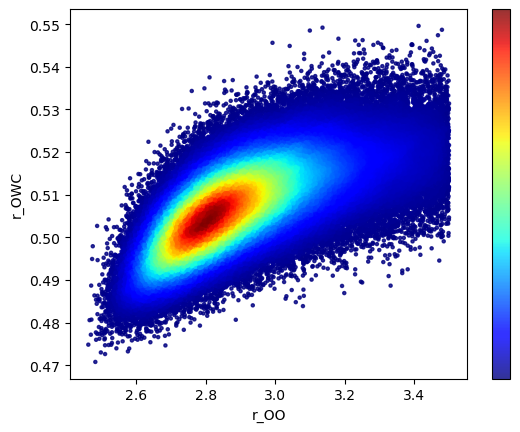

In [46]:
#
# * 計算結果の図示

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.ticker as mticker

# plt.scatter(data[:,0],data[:,1])

# https://qiita.com/kujira_0120/items/c00a7bb22144ad6c565c
dataset = np.vstack([data[:,0], data[:,1]])
kde = gaussian_kde(dataset)
density = kde(dataset)

plt.scatter(data[:,0], data[:,1], c=density, s=5, marker='o', cmap='jet', alpha=0.8)
plt.xlabel("r_OO")
plt.ylabel("r_OWC")
# カラーバーを追加
cb = plt.colorbar(ticks=mticker.NullLocator())

In [38]:
# np.savetxt("data.txt",data)

In [55]:
#
# * plotしたいデータ


xtick = np.linspace(2.4,3.5,100)
ytick = np.linspace(0.47,0.55,100)

X, Y = np.meshgrid(xtick, ytick)

estimated_value = kde(np.vstack([X.reshape(-1), Y.reshape(-1)]))


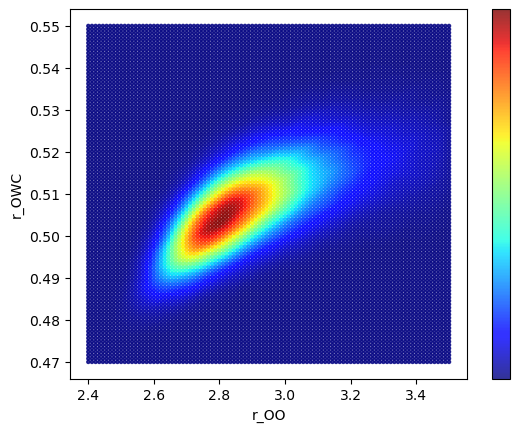

In [57]:
plt.scatter(X.reshape(-1), Y.reshape(-1), c=estimated_value , s=5, marker='o', cmap='jet', alpha=0.8)
plt.xlabel("r_OO")
plt.ylabel("r_OWC")
# カラーバーを追加
cb = plt.colorbar(ticks=mticker.NullLocator())

In [63]:

data_noHB = []
data_HB = []
for counter,atoms in enumerate(traj):
    # positions = atom
    for mol_id in range(NUM_MOL): # donor, acceptorの順
        # r_wc   = np.linalg.norm(position_WC[counter,mol_id] - (position_O[counter,mol_id]+position_H[counter,mol_id])/2)
        r_wc   = np.linalg.norm(position_WC[counter,mol_id] - position_O[counter,mol_id])
        # HBかどうか
        if np.sum(IF_HB[counter,mol_id]) == True:
            data_HB.append(r_wc)
        else:
            data_noHB.append(r_wc)
                
data_noHB = np.array(data_noHB)
data_HB = np.array(data_HB)

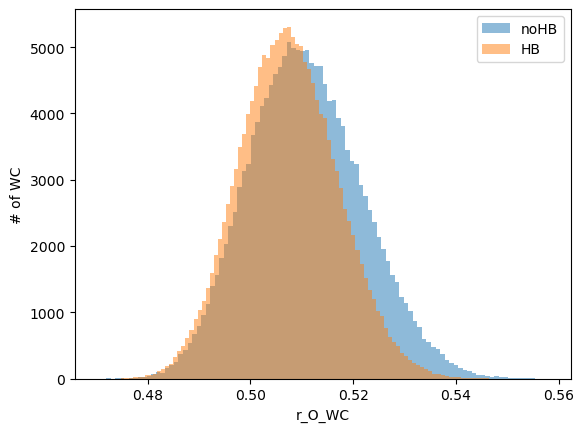

In [67]:
plt.hist(data_noHB,bins=100, alpha=0.5, label="noHB")
plt.hist(data_HB,bins=100, alpha=0.5, label="HB")
plt.xlabel("r_O_WC")
plt.ylabel("# of WC")
plt.legend()
